In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)
from torch import nn
import torch.nn.functional as F
import torchzero as tz
from visualbench import FunctionDescent, test_functions

# 9. Trust region

### 9.1 Introduction
Recall from [5. Second order methods](<../5. Second order methods>) that whenever we have hessian or hessian estimate, the objective function is modelled by a quadratic model, where given gradient $g$ and hessian $H$, the model is:
$$
f(v) = \frac{1}{2}v^T H v + g^T v
$$

If the objective function has higher order terms or discontinuities, the quadratic model becomes less and less accurate the further we get from the current point. We therefore introduce **trust region** - region around the current point where our quadratic model is considered accurate.

Here is a general trust region algorithm scheme:

1. At the current point $x_t$ obtain gradient $g_t$, hessian or a hessian estimate $H_t$, then our quadratic model is given by $f_{\mathbb{quad}}(v) = \frac{1}{2}v^T H_t v + g_t^T v$. Importantly the quadratic model is centered around zero, so $f_{\mathbb{quad}}(v)$ corrensponds to $f(x_t + v)$. We have trust radius value $\tau_t$, which is size of the region where quadratic model is assumed to be accurate.

2. Trust region subproblem: minimize the quadratic model within the trust radius $\tau_t$ to obtain the solution $\hat{v}$. That means we want to minimize $f_{\mathbb{quad}}(\hat{v}) = \frac{1}{2}\hat{v}^T H_t \hat{v} + g_t^T \hat{v}$ under the constraint that $x_t + \hat{v}$ isn't far from $x_t$. What "too far" means depends on a specific trust region algorithm, for example we can impose an L2 norm constraint: $||\hat{v}||_2 \leq \tau_t$.

3. Evaluate function value at solution $\hat{v}$ of the objective function $F_{\mathbb{true}} = f(x_t + \hat{v})$ and of the quadratic model $F_{\mathbb{predicted}} = \frac{1}{2}\hat{v}^T H_t \hat{v} + g_t^T \hat{v}$. If the values $F_{\mathbb{true}}$ and $F_{\mathbb{predicted}}$ are close, the quadratic model is accurate within trust radius $\tau_t$ and we can try to increase the trust radius. If the values are very different, the quadratic model within trust radius $\tau_t$ is inaccurate, therefore we decrease trust radius. The particular strategy of how to change $\tau_t$ depends on trust region algorithm.

4. If solution $\hat{v}$ is better, accept it: if $f(x_t + \hat{v}) \le f(x_t)$, set $x_{t+1} \leftarrow x_t + \hat{v}$. Otherwise we stay at $x_t$, reduce the trust radius and restart from step 2.

### 9.2 Levenberg Marquardt
The Levenberg–Marquardt algorithm (LM) is also known as the damped least-squares method, as it is commonly used as trust region for least squares problems, however it works well for minimization problems too.

In LM scaled identity matrix is added to the hessian matrix before solving the linear system, and the smaller trust radius is, the larger the identity matrix scale is. Given gradient $g_t$, hessian $H_t$ and trust radius $\tau_t$, the trust region solution $\hat{v}$ is given by solving $(H_t + \frac{1}{\tau_t} I )\hat{v} = g_t$.

Geometrically solving $(H_t + \frac{1}{\tau_t} I )\hat{v} = g_t$ constrains $d_t$ to have L2 norm no larger than some value which becomes smaller as identity matrix scale becomes larger, however there is no simple correspondance between $\tau_t$ and that value. In fact in some implementatations $\tau_t$ determines L2 norm bound, then appropriate identity matrix scale is found using root finding, which requires multiple linear system solves. In torchzero we just use $\frac{1}{\tau_t} I$ because it seems to work just as well with a single solve.

When LM is used with Gauss-Newton, identity matrix is often replaced by diagonal of Gauss-Newton hessian approximation.

A note on terminology - "Levenberg-Marquardt" often refers specifically to Gauss-Newton with this kind of trust region. The trust region itself is called "Levenberg–Marquardt penalty". Newton's method with this penality is sometimes called "Regularized Newton", although that can also refer to other regularizers.

`LevenbergMarquardt` is the trust region that I recommend in most cases because it is fast to compute and has good performance. The only downside is that in involves adding a diagonal matrix, which is not possible in some cases where full matrix isn't formed such as L-BFGS.

finished in 1.0s., reached loss = 0                                      
finished in 0.5s., reached loss = 0                                      
finished in 0.3s., reached loss = 1.98e-11                                      


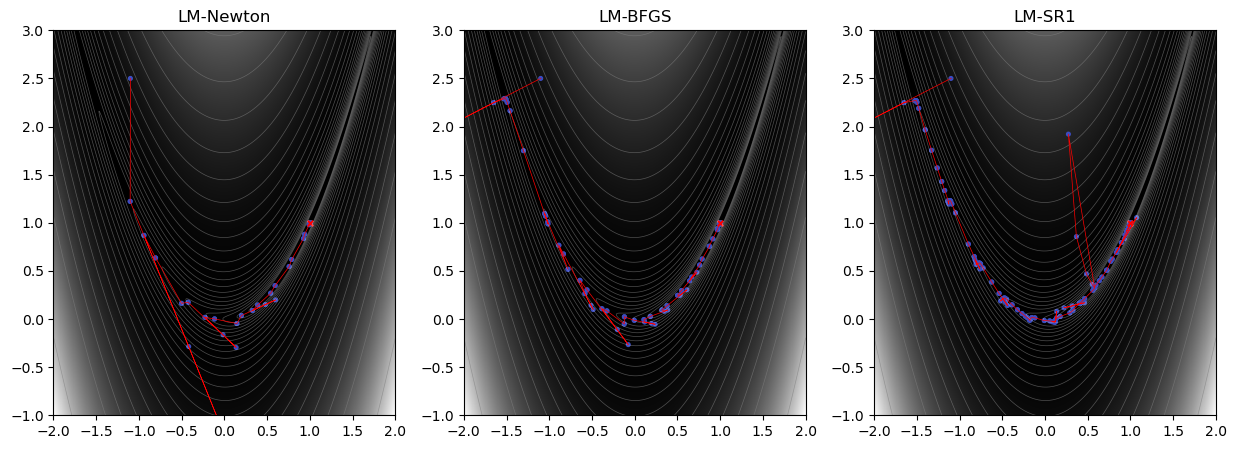

In [2]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax = np.ravel(ax)

# --------------------------------- Newton --------------------------------- #
func = FunctionDescent('rosen')
optimizer = tz.Modular(func.parameters(), tz.m.LevenbergMarquardt(tz.m.Newton()))
func.run(optimizer, max_steps=100)
func.plot(log_contour=True, ax=ax[0])
ax[0].set_title("LM-Newton")

# ----------------------------------- BFGS ----------------------------------- #
func = FunctionDescent('rosen')
optimizer = tz.Modular(func.parameters(), tz.m.LevenbergMarquardt(tz.m.BFGS(inverse=False)))
func.run(optimizer, max_steps=100)
func.plot(log_contour=True, ax=ax[1])
ax[1].set_title("LM-BFGS")

# ------------------------------------ SR1 ----------------------------------- #
func = FunctionDescent('rosen')
optimizer = tz.Modular(func.parameters(), tz.m.LevenbergMarquardt(tz.m.SR1(inverse=False)))
func.run(optimizer, max_steps=100)
func.plot(log_contour=True, ax=ax[2])
ax[2].set_title("LM-SR1")

plt.show()

### 9.3 TrustCG
`TrustCG` solves $Hv=g$ using an iterative conjugate gradient (CG) solver. By using the fact that norm of the the direction $v$ increases with each CG iteration, when $v$ becomes larger than our trust radius $\tau_t$ or when negative curvature is detected, CG is terminated and $v$ is modified to be within the trust radius and returned.

Unlike Levenberg-Marquardt, here $\tau_t$ corresponds directly to L2 norm of the update. `TrustCG`, being an iterative method, is typically slower than Levenberg-Marquardt to compute, however it has the advantage that it only uses matrix-vector multiplications, making it suitable for limited memory methods such as L-BFGS.

finished in 0.7s., reached loss = 0                                      
finished in 0.6s., reached loss = 0                                      
finished in 0.4s., reached loss = 0                                      


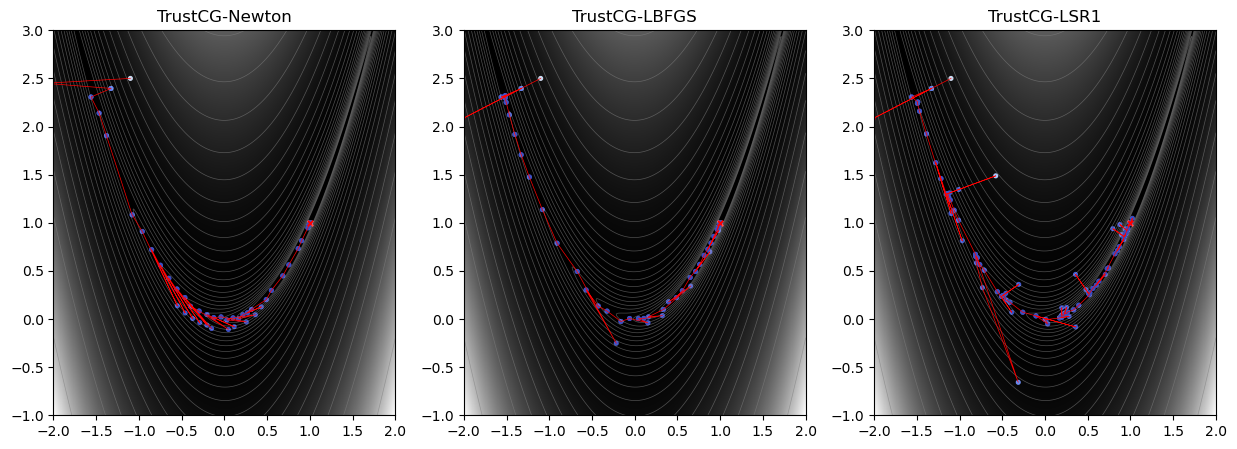

In [3]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax = np.ravel(ax)

# --------------------------------- Newton --------------------------------- #
func = FunctionDescent('rosen')
optimizer = tz.Modular(func.parameters(), tz.m.TrustCG(tz.m.Newton()))
func.run(optimizer, max_steps=100)
func.plot(log_contour=True, ax=ax[0])
ax[0].set_title("TrustCG-Newton")

# ----------------------------------- BFGS ----------------------------------- #
func = FunctionDescent('rosen')
optimizer = tz.Modular(func.parameters(), tz.m.TrustCG(tz.m.BFGS(inverse=False)))
func.run(optimizer, max_steps=100)
func.plot(log_contour=True, ax=ax[1])
ax[1].set_title("TrustCG-LBFGS")

# ------------------------------------ SR1 ----------------------------------- #
func = FunctionDescent('rosen')
optimizer = tz.Modular(func.parameters(), tz.m.TrustCG(tz.m.SR1(inverse=False)))
func.run(optimizer, max_steps=100)
func.plot(log_contour=True, ax=ax[2])
ax[2].set_title("TrustCG-LSR1")

plt.show()

### 9.4 Powell's dog leg method

The dog leg method takes cauchy point - minimizer of the quadratic model along the steepest descent direction, it takes Newton's step point, and draws a line between them. The intersection of that line with a circle of radius $\tau_t$ is the solution to the trust region subproblem. If circle radius is so small that the line is outside it, it uses intersection between the circle and the cauchy point line.

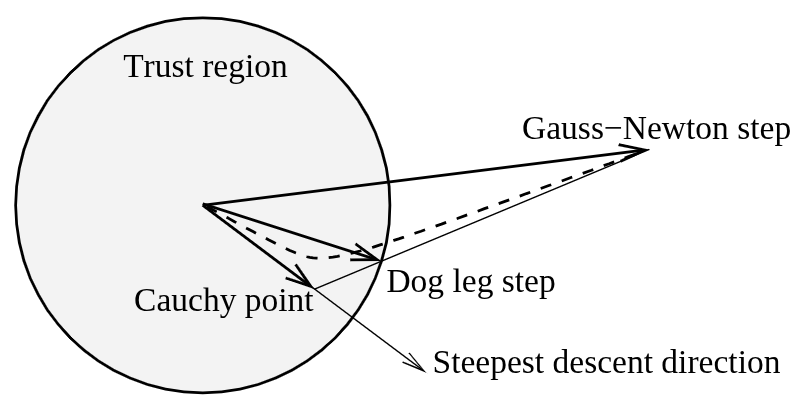

Image from [Lourakis, Manolis LA, and Antonis A. Argyros. "Is Levenberg-Marquardt the most efficient optimization algorithm for implementing bundle adjustment?." Tenth IEEE International Conference on Computer Vision (ICCV'05) Volume 1. Vol. 2. IEEE, 2005.](https://publications.ics.forth.gr/_publications/0201-P0401-lourakis-levenberg.pdf)

Dog leg method is only suitable for Newton and Gauss-Newton, and doesn't work well with hessian approximations. It has similar computational cost to Levenberg–Marquardt.

finished in 0.8s., reached loss = 0                                      
finished in 0.8s., reached loss = 2.596                                      
finished in 0.9s., reached loss = 4.924                                      


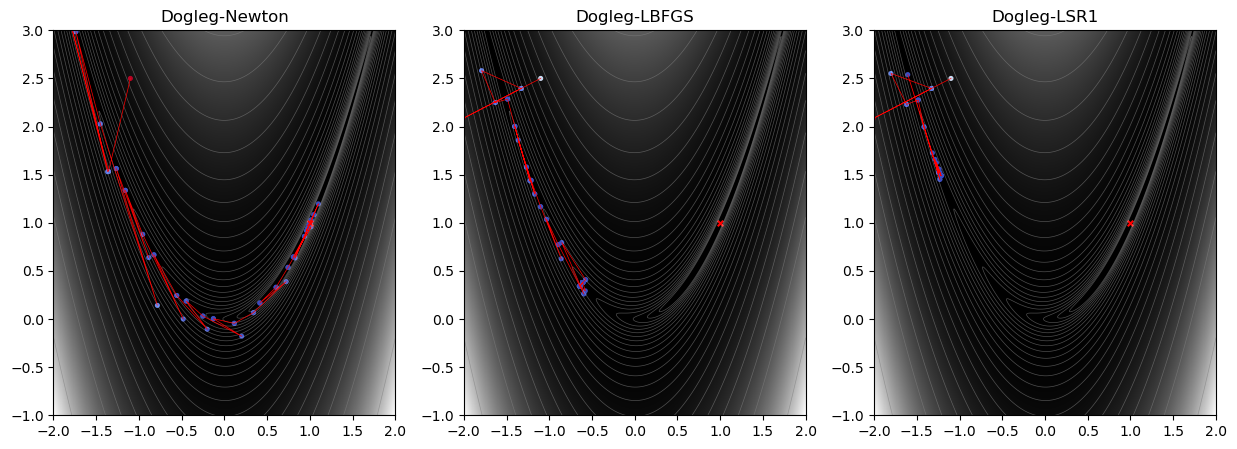

In [4]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax = np.ravel(ax)

# --------------------------------- Newton --------------------------------- #
func = FunctionDescent('rosen')
optimizer = tz.Modular(func.parameters(), tz.m.Dogleg(tz.m.Newton()))
func.run(optimizer, max_steps=100)
func.plot(log_contour=True, ax=ax[0])
ax[0].set_title("Dogleg-Newton")

# ----------------------------------- BFGS ----------------------------------- #
func = FunctionDescent('rosen')
optimizer = tz.Modular(func.parameters(), tz.m.Dogleg(tz.m.BFGS(inverse=False)))
func.run(optimizer, max_steps=100)
func.plot(log_contour=True, ax=ax[1])
ax[1].set_title("Dogleg-LBFGS")

# ------------------------------------ SR1 ----------------------------------- #
func = FunctionDescent('rosen')
optimizer = tz.Modular(func.parameters(), tz.m.Dogleg(tz.m.SR1(inverse=False)))

func.run(optimizer, max_steps=100)
func.plot(log_contour=True, ax=ax[2])
ax[2].set_title("Dogleg-LSR1")

plt.show()

### 9.5 Cubic regularization

Cubic regularization adds an extra cubic term  $||v||^3$ to the trust region subproblem, penalizing cubed norm of update dirction $v$. Therefore the trust region subproblem becomes:

$$
f_{\mathbb{subproblem}}(v) = \frac{1}{2}v^T H_t v + g_t^T v + \frac {\tau}{6}||v||^3
$$

Here $\tau$ controls strength of the penalty and has a similar function to trust radius. Solvers exist that solve this subproblem relatively efficiently, although it is still more computationally expensive than other trust region methods. For torchzero I used the solver implemented here https://github.com/konstmish/opt_methods/blob/master/optmethods/second_order/cubic.py

Cubic regularization seems to work better with exact hessian than with approximation. With exact hessian the convergence can be better than other trust region methods at a cost of being more computationally expensive.

finished in 1.1s., reached loss = 0                                      
finished in 1.0s., reached loss = 0                                      
finished in 0.9s., reached loss = 0.0437                                      


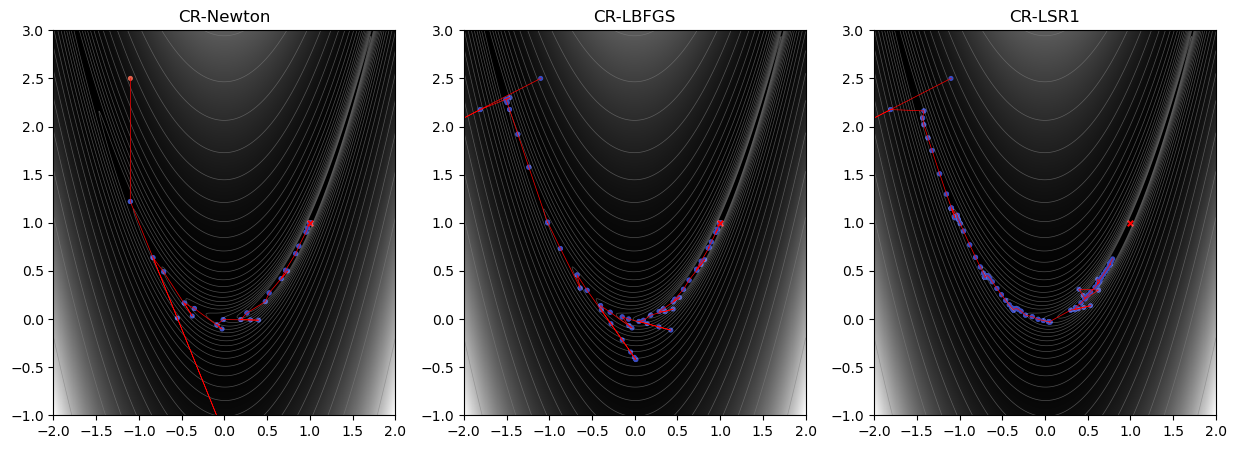

In [5]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax = np.ravel(ax)

# --------------------------------- Newton --------------------------------- #
func = FunctionDescent('rosen')
optimizer = tz.Modular(func.parameters(), tz.m.CubicRegularization(tz.m.Newton()))
func.run(optimizer, max_steps=100)
func.plot(log_contour=True, ax=ax[0])
ax[0].set_title("CR-Newton")

# ----------------------------------- BFGS ----------------------------------- #
func = FunctionDescent('rosen')
optimizer = tz.Modular(func.parameters(), tz.m.CubicRegularization(tz.m.BFGS(inverse=False)))
func.run(optimizer, max_steps=100)
func.plot(log_contour=True, ax=ax[1])
ax[1].set_title("CR-LBFGS")

# ------------------------------------ SR1 ----------------------------------- #
func = FunctionDescent('rosen')
optimizer = tz.Modular(func.parameters(), tz.m.CubicRegularization(tz.m.SR1(inverse=False)))

func.run(optimizer, max_steps=100)
func.plot(log_contour=True, ax=ax[2])
ax[2].set_title("CR-LSR1")

plt.show()